# Aubio Optimization Results
This notebook produces plots and tables that represent the results of the performance evaluation on Aubio

## Data import and preprocessing
Remember to change the first line of the next cell with the correct csv path

In [37]:
FILEPATH = "/content/AubioStudyCOMPLESSIVE - Study2_EA_CSV.csv" 

import pandas as pd
import numpy as np

df = pd.read_csv(FILEPATH,sep=',',decimal = '.',skip_blank_lines=True) # Hey you have to go to the link on the top description and export sheet 2

best_results = dict.fromkeys(pd.unique(df['Method'])) # Create dictionary for results
buffersizes = np.sort(pd.unique(df['Buffer Size']))   # Create list of buffer size entries
methods = best_results.keys()                         # Create list of Aubio methods from the keys of the dict (handy)
for method in best_results.keys():                    # Create dicts for each buffer size in each method key
  best_results[method] = dict.fromkeys(buffersizes)
print("Data imported")

Data imported


In [38]:
### Extract best results from CSV ###

bestresIds = []
solution_counter = 0
for method in best_results.keys():
  for buffer_size in best_results[method].keys():
    res = dict.fromkeys(['id','method','buffer_size','macroavg_f1'])

    subdf = df.loc[(df['Method'] == method) & (df['Buffer Size'] == buffer_size)]
    if not subdf.empty:
      argmax = subdf['MAvg_t f1'].argmax()
      res['id'] = subdf['ID'].to_numpy()[argmax]
      bestresIds.append(res['id'])
      res['method'] = subdf['Method'].to_numpy()[argmax]
      res['buffer_size'] = subdf['Buffer Size'].to_numpy()[argmax]
      res['macroavg_f1'] = subdf['MAvg_t f1'].to_numpy()[argmax]           # MAvg_t f1 is the third f1 column, containing the macro average between techniques (Look back at Google Sheet)
      res['adj_min'] = subdf['MAvg_t loTukeyFence'].to_numpy()[argmax]
      res['adj_max'] = subdf['MAvg_t hiTukeyFence'].to_numpy()[argmax]
      res['avg'] = subdf['MAvg_t Mean'].to_numpy()[argmax]
      res['percentage'] = subdf['MAvg_t percentageIn'].to_numpy()[argmax]
      res['IQR'] = subdf['MAvg_t IQR'].to_numpy()[argmax]

      best_results[method][buffer_size] = res
      solution_counter += 1
print(str(solution_counter)+" best solutions found in data")


54 best solutions found in data


## Process Results

## Find Pareto fronts
(Different Objective choices)

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if scores[j][0] < scores[i][0] and scores[j][1] > scores[i][1]:
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]
    
def sort_front(front):
  front_df = pd.DataFrame(front)
  front_df.sort_values(0, inplace=True)
  return front_df.values
print("Pareto-front utilities defined")

Pareto-front utilities defined


#### Compute Pareto front with delay INTER QUARTILE RANGE and macroavg.f1 as objectives


IQR Pareto front scores
[['0.7975' '0.8449' '42' 'specflux']
 ['0.8052' '0.9243' '44' 'specflux']
 ['0.88' '0.9518' '48' 'mkl(noaw)']
 ['0.8915' '0.9742' '50' 'mkl(noaw)']]


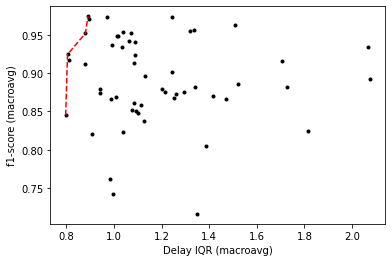

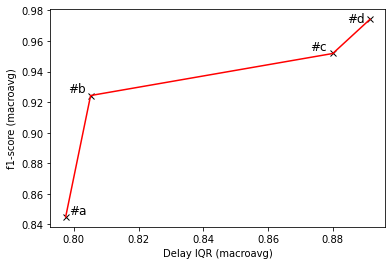

,#,Method,F1-score,Low Tukey fence (ms),Delay mean (ms),High Tukey fence (ms),Onsets inside fences (%),MAvg_t IQR
42,a,specflux,0.8449,2.1546,3.7841,5.3447,95.54,0.7975
44,b,specflux,0.9243,3.1097,4.8164,6.3303,93.52,0.8052
48,c,mkl(noaw),0.9518,2.7264,4.5436,6.2465,96.89,0.8800
50,d,mkl(noaw),0.9742,4.1830,6.0272,7.7491,96.11,0.8915





\begin{table}
\centering
\caption{Pareto front solution with f1-score (macro average over all techniques) as the first objective and Interquartile Range of latency as the second.}
\label{%TODO: add label}
\begin{tabular}{llrrrrrr}
\toprule
 \# &     Method &  F1-score &  Low Tukey fence (ms) &  Delay mean (ms) &  High Tukey fence (ms) &  Onsets inside fences (\%) &  MAvg\_t IQR \\
\midrule
 a &   specflux &    0.8449 &                2.1546 &           3.7841 &                 5.3447 &                     95.54 &      0.7975 \\
 b &   specflux &    0.9243 &                3.1097 &           4.8164 &                 6.3303 &                     93.52 &      0.8052 \\
 c &  mkl(noaw) &    0.9518 &                2.7264 &           4.5436 &                 6.2465 &                     96.89 &      0.8800 \\
 d &  mkl(noaw) &    0.9742 &                4.1830 &           6.0272 &                 7.7491 &                     96.11 &      0.8915 \\
\bottomrule
\end{tabular}
\end{table}



In [40]:
iqr_all_scores = []
for method in best_results.keys():
  for buffer_size in best_results[method].keys():
    currentres = best_results[method][buffer_size]
    if currentres == None:
      continue
    iqr_all_scores.append([currentres['IQR'],currentres['macroavg_f1'],int(currentres['id']),method])
iqr_all_scores = np.array(iqr_all_scores)

IQRrange_pareto_front = iqr_all_scores[identify_pareto(iqr_all_scores[:,0:2])]
print ('\nIQR Pareto front scores')
print (IQRrange_pareto_front)

IQRrange_pareto_front = sort_front(IQRrange_pareto_front)

ax = plt.gca()
plt.plot(iqr_all_scores[:, 0].astype(dtype=float), iqr_all_scores[:, 1].astype(dtype=float),'k.')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.ylim(0.8,1)
# plt.xlim(4.5,16)
plt.plot(IQRrange_pareto_front[:, 0].astype(dtype=float), IQRrange_pareto_front[:, 1].astype(dtype=float),'r--')
plt.ylabel('f1-score (macroavg)')
plt.xlabel('Delay IQR (macroavg)')

plt.savefig('/content/iqr_pareto_1.pdf')  
plt.show()

plt.plot(IQRrange_pareto_front[:, 0].astype(dtype=float), IQRrange_pareto_front[:, 1].astype(dtype=float),'xk')
plt.plot(IQRrange_pareto_front[:, 0].astype(dtype=float), IQRrange_pareto_front[:, 1].astype(dtype=float),'r-')
plt.ylabel('f1-score (macroavg)')
plt.xlabel('Delay IQR (macroavg)')

''' ADD TEXT'''

iqr_front_df = pd.DataFrame(IQRrange_pareto_front)
iqr_front_df['newindex'] = list(map(chr, range(97, 123)))[:len(iqr_front_df)]
new_IQRrange_pareto_front = iqr_front_df.astype({0:float, 1:float, 2:float, 3:object, 'newindex':object}).values

for (x,y,id,method,newid) in new_IQRrange_pareto_front[:,:]:
  x = float(x)
  y = float(y)
  yoffset = -0.002 if y > 0.96 else 0.002
  xoffset = -0.007 if x > 0.8 else 0.001
  plt.text(x+xoffset, y+yoffset, '#'+str(newid), fontsize=12)
plt.savefig('/content/iqr_pareto_2.pdf')  
plt.show()

IQRrange_pareto_table = df.iloc[IQRrange_pareto_front[:,2].astype(int),:]
IQRrange_pareto_table = IQRrange_pareto_table.assign(ID=new_IQRrange_pareto_front[:,4])
IQRrange_pareto_table = IQRrange_pareto_table[['ID','Method', \
                                           'MAvg_t f1', \
                                           'MAvg_t loTukeyFence', \
                                           'MAvg_t Mean', \
                                           'MAvg_t hiTukeyFence', \
                                           'MAvg_t percentageIn', \
                                           'MAvg_t IQR']].rename(columns = {'ID': '#', \
                                                                                     'MAvg_t f1': 'F1-score', \
                                                                                     'MAvg_t loTukeyFence':'Low Tukey fence (ms)', \
                                                                                     'MAvg_t Mean' : 'Delay mean (ms)', \
                                                                                     'MAvg_t hiTukeyFence':'High Tukey fence (ms)', \
                                                                                     'MAvg_t percentageIn':'onsets_inside_fences'}, inplace = False)
percentages = IQRrange_pareto_table['onsets_inside_fences']*100
IQRrange_pareto_table = IQRrange_pareto_table.assign(onsets_inside_fences = percentages)
IQRrange_pareto_table = IQRrange_pareto_table.rename(columns = {'onsets_inside_fences': 'Onsets inside fences (%)'}, inplace = False)

# IQRrange_pareto_table = IQRrange_pareto_table.astype({'#':int})
display(IQRrange_pareto_table)
print('\n\n')

IQRrange_latextable = IQRrange_pareto_table.to_latex(index=False,caption="Pareto front solution with f1-score (macro average over all techniques) as the first objective and Interquartile Range of latency as the second.",label="%TODO: add label")
print(IQRrange_latextable)

with open("iqr_pareto_table.tex",'w') as file:
  file.write(IQRrange_latextable)

#### Compute Pareto front with MAX fence (mav value without outliers) and macroavg.f1 as objectives


Adjmax Pareto front scores
[['6.1275' '0.941' '6' 'energy']
 ['4.4454' '0.762' '18' 'phase']
 ['5.3447' '0.8449' '42' 'specflux']
 ['5.8269' '0.9175' '43' 'specflux']
 ['6.2465' '0.9518' '48' 'mkl(noaw)']
 ['6.8334' '0.9708' '49' 'mkl(noaw)']
 ['7.7491' '0.9742' '50' 'mkl(noaw)']]


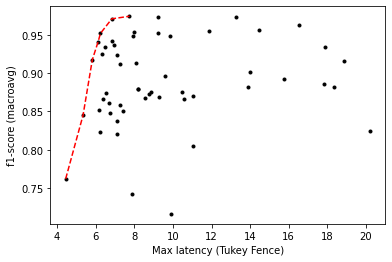

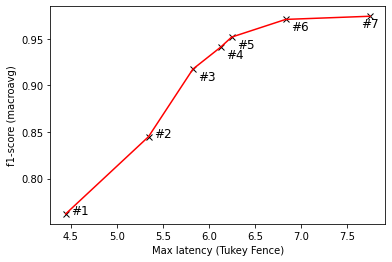

,#,Method,F1-score,Low Tukey fence (ms),Delay mean (ms),High Tukey fence (ms),Onsets inside fences (%)
18,1,phase,0.7620,0.5048,2.6409,4.4454,93.19
42,2,specflux,0.8449,2.1546,3.7841,5.3447,95.54
43,3,specflux,0.9175,2.5741,4.2824,5.8269,94.88
6,4,energy,0.9410,1.7774,4.0118,6.1275,97.03
48,5,mkl(noaw),0.9518,2.7264,4.5436,6.2465,96.89
49,6,mkl(noaw),0.9708,3.2457,5.1005,6.8334,96.74
50,7,mkl(noaw),0.9742,4.1830,6.0272,7.7491,96.11





\begin{table}
\centering
\caption{Pareto front solution with f1-score (macro average over all techniques) as the first objective and maximum latency as the second, in the form of upper Tukey fence.}
\label{%TODO: add label}
\begin{tabular}{rlrrrrr}
\toprule
 \# &     Method &  F1-score &  Low Tukey fence (ms) &  Delay mean (ms) &  High Tukey fence (ms) &  Onsets inside fences (\%) \\
\midrule
 1 &      phase &    0.7620 &                0.5048 &           2.6409 &                 4.4454 &                     93.19 \\
 2 &   specflux &    0.8449 &                2.1546 &           3.7841 &                 5.3447 &                     95.54 \\
 3 &   specflux &    0.9175 &                2.5741 &           4.2824 &                 5.8269 &                     94.88 \\
 4 &     energy &    0.9410 &                1.7774 &           4.0118 &                 6.1275 &                     97.03 \\
 5 &  mkl(noaw) &    0.9518 &                2.7264 &           4.5436 &                 6.24

In [41]:
scores = []
for method in best_results.keys():
  for buffer_size in best_results[method].keys():
    currentres = best_results[method][buffer_size]
    if currentres == None:
      continue
    scores.append([currentres['adj_max'],currentres['macroavg_f1'],currentres['id'],method])
scores = np.array(scores)

maxfence_pareto_front = scores[identify_pareto(scores[:,0:2].astype(float))]
print ('\nAdjmax Pareto front scores')
print (maxfence_pareto_front)

maxfence_pareto_front = sort_front(maxfence_pareto_front)

x_all = scores[:, 0].astype(dtype=float)
y_all = scores[:, 1].astype(dtype=float)
x_pareto = maxfence_pareto_front[:, 0].astype(dtype=float)
y_pareto = maxfence_pareto_front[:, 1].astype(dtype=float)


ax = plt.gca()
plt.plot(x_all, y_all,'.k')
plt.plot(x_pareto, y_pareto,'r--')
plt.ylabel('f1-score (macroavg)')
plt.xlabel('Max latency (Tukey Fence)')

plt.savefig('/content/maxfence_pareto_1.pdf')  
plt.show()

plt.plot(x_pareto, y_pareto,'xk')
plt.plot(x_pareto, y_pareto,'r-')
plt.ylabel('f1-score (macroavg)')
plt.xlabel('Max latency (Tukey Fence)')

''' ADD TEXT'''

maxfence_front_df = pd.DataFrame(maxfence_pareto_front)
maxfence_front_df['newindex'] = range(1, len(maxfence_front_df) + 1)
new_maxfence_front = maxfence_front_df.values

for (x,y,id,method,newid) in new_maxfence_front[:,:]:
  x = float(x)
  y = float(y)
  yoffset = 0 if y < 0.9 else -0.012
  xoffset = -0.1 if x > 7 else 0.06
  plt.text(x+xoffset, y+yoffset, '#'+str((int)(newid)), fontsize=12)
plt.savefig('/content/maxfence_pareto_2.pdf')  
plt.show()

maxfence_pareto_table = df.iloc[maxfence_pareto_front[:,2].astype(float).astype(int),:]
maxfence_pareto_table = maxfence_pareto_table.assign(ID=new_maxfence_front[:,4])
maxfence_pareto_table = maxfence_pareto_table[['ID','Method', \
                                           'MAvg_t f1', \
                                           'MAvg_t loTukeyFence', \
                                           'MAvg_t Mean', \
                                           'MAvg_t hiTukeyFence', \
                                           'MAvg_t percentageIn']].rename(columns = {'ID': '#', \
                                                                                     'MAvg_t f1': 'F1-score', \
                                                                                     'MAvg_t loTukeyFence':'Low Tukey fence (ms)', \
                                                                                     'MAvg_t Mean' : 'Delay mean (ms)', \
                                                                                     'MAvg_t hiTukeyFence':'High Tukey fence (ms)', \
                                                                                     'MAvg_t percentageIn':'onsets_inside_fences'}, inplace = False)
percentages = maxfence_pareto_table['onsets_inside_fences']*100
maxfence_pareto_table = maxfence_pareto_table.assign(onsets_inside_fences = percentages)
maxfence_pareto_table = maxfence_pareto_table.rename(columns = {'onsets_inside_fences': 'Onsets inside fences (%)'}, inplace = False)

maxfence_pareto_table = maxfence_pareto_table.astype({'#':int})
display(maxfence_pareto_table)
print('\n\n')
maxfence_latextable = maxfence_pareto_table.to_latex(index=False,caption="Pareto front solution with f1-score (macro average over all techniques) as the first objective and maximum latency as the second, in the form of upper Tukey fence.",label="%TODO: add label")
print(maxfence_latextable)

with open("maxfence_pareto_table.tex",'w') as file:
  file.write(maxfence_latextable)


### More in-depth analysis of the points from different methods
(with particular attention to non-whitened MKL)

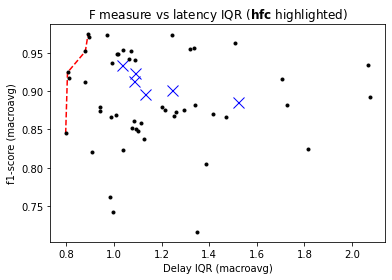

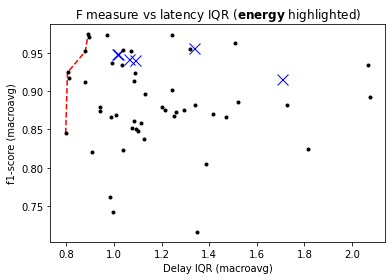

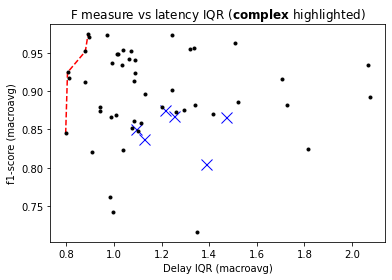

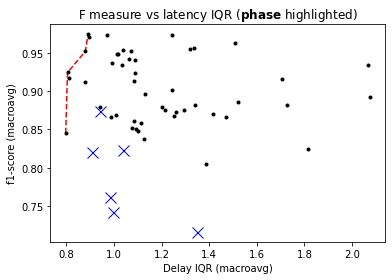

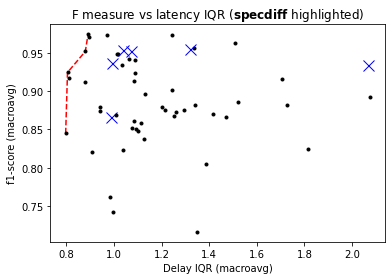

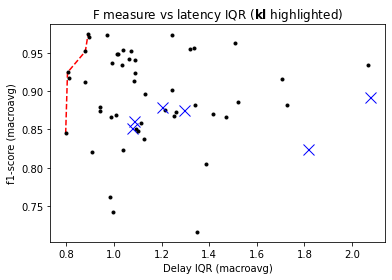

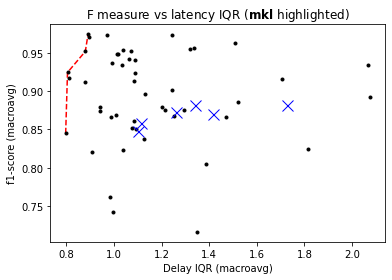

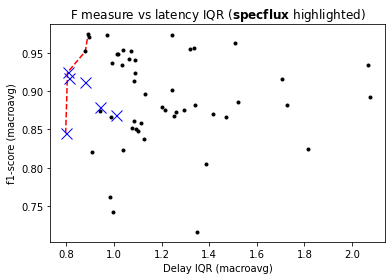

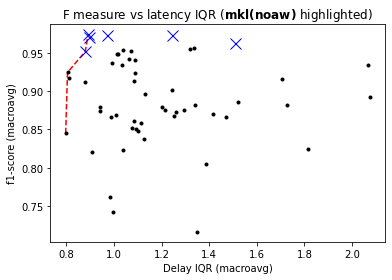

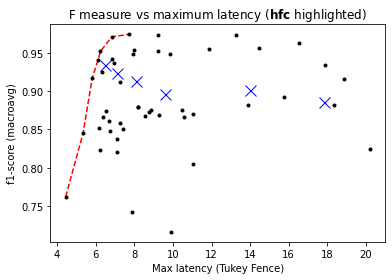

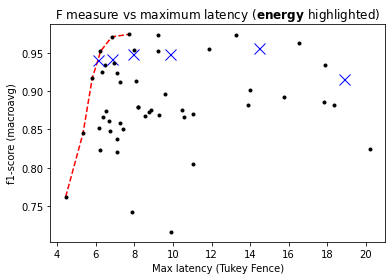

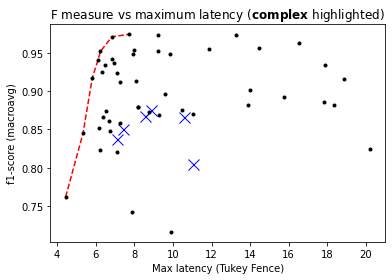

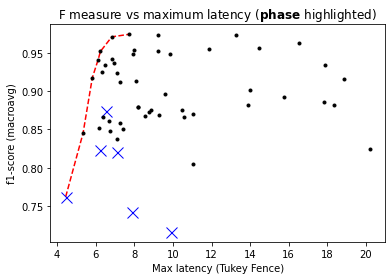

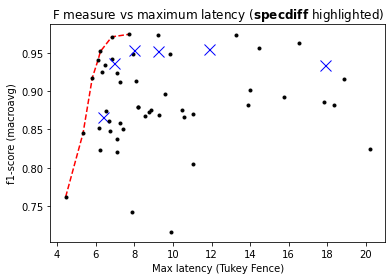

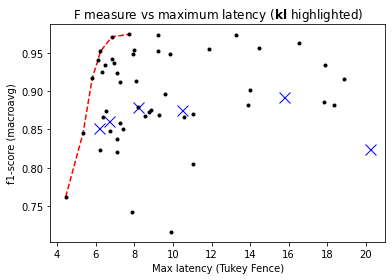

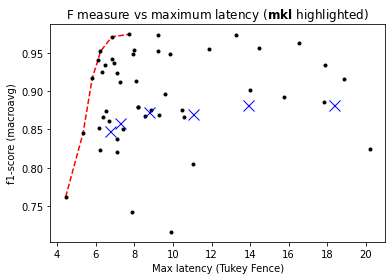

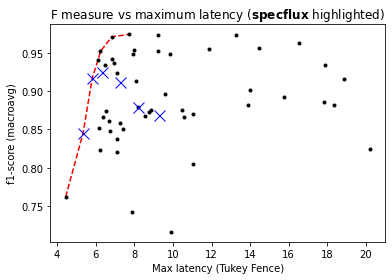

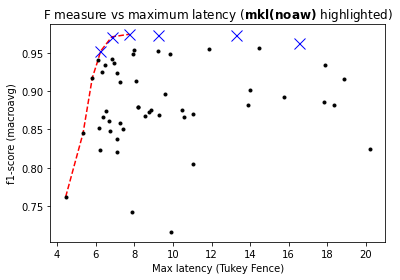

In [42]:
# ON_WHICH_ANALYSIS = 'IQR' # or hiFence (minimum upper tukey fence)
ON_WHICH_ANALYSIS = 'hiFence' # or IQR

# ON_WHICH_METHOD = 'mkl (No whitening)'
ON_WHICH_METHOD = 'phase'

DO_CROP = None
# DO_CROP = ((0.8,1),(0.75,1.6))

analysis_data = {'IQR':(iqr_all_scores,IQRrange_pareto_front),'hiFence':(scores,maxfence_pareto_front)}

# def selector(data,data2,choice=0)

def method_analysis(_data,method,analysis,crop=None,color='b',marker=('.',None)):
    allscores = _data[0]
    pareto_allscores = _data[1]
    Xs = allscores[:, 0].astype(dtype=float)
    Ys = allscores[:, 1].astype(dtype=float)
    pXs = pareto_allscores[:, 0].astype(dtype=float)
    pYs = pareto_allscores[:, 1].astype(dtype=float)
    assert(len(color) == 1)
    assert(len(marker) == 2)
    ax = plt.gca()
    if crop:
        assert(len(crop) == 2)
        assert(len(crop[0]) == 2)
        assert(len(crop[1]) == 2)
        plt.ylim(crop[0]) # example (0.8,1)
        plt.xlim(crop[1]) # example (0.75,1.6)
    plt.plot(pXs, pYs, 'r--')
    for elem in allscores:
        if elem[3] == method:
            plt.plot(float(elem[0]), float(elem[1]),color+marker[0],markersize=8 if marker[1] is None else marker[1])
        else:
            plt.plot(float(elem[0]), float(elem[1]),'k.')
    plt.ylabel('f1-score (macroavg)')
    if analysis == 'IQR':
        plt.xlabel('Delay IQR (macroavg)')
        objectivestring = 'F measure vs latency IQR'
    elif analysis == 'hiFence':
        plt.xlabel('Max latency (Tukey Fence)')
        objectivestring = 'F measure vs maximum latency'
    else:
        raise ValueError("Bad analysis value")

    plt.title(objectivestring + ' ('+ r"$\bf{" + method+"}$"+' highlighted)')
    import os
    ID_DIRNAME='indepth'
    try:
        os.mkdir(ID_DIRNAME)
    except:
        None
    plt.savefig('/content/'+ID_DIRNAME+'/indepth_'+str(analysis)+'_'+method+'.pdf')  
    plt.show()

methods = list(best_results.keys())
colors = ['b']  # ['b','g','r','c','m','y']
markers = ['x'] # ['o','v','^','<','>','s','*','h','H','+','x','D','d','|','_']
for analysis in analysis_data.keys():
    for i in range(0,len(methods)):
        method_analysis(analysis_data[analysis],methods[i],analysis=analysis,color=colors[i%len(colors)], marker = (markers[i%len(markers)],11))

## Tables

In [43]:
# Mark Pareto front values (2 objectives: low maximum latency and high macro avg f1)

for method in best_results.keys():
  argmax = None
  max = 0.0
  for buffer_size in best_results[method].keys():
    # Mark pareto front of maximum adj value
    currentres = best_results[method][buffer_size]
    if currentres == None:
      continue
    current_id = currentres['id']
    # print(str(current_id) + "["+str(maxfence_pareto_front[:,2].astype(int))+"]")
    if current_id in maxfence_pareto_front[:,2].astype(int):
      best_results[method][buffer_size]['ispareto_fence_max'] = True
    # Mark pareto front of adj range value
    if current_id in IQRrange_pareto_front[:,2].astype(int):
      best_results[method][buffer_size]['ispareto_iqr_range'] = True

In [44]:
table_header = '\\begin{table}[htbp]'+"\n" + \
               '\\begin{tabular}{lc|'+('c'*len(buffersizes))+'|}'+"\n" + \
               '\\cline{3-'+str(len(buffersizes)+2)+'}'+"\n" + \
               ' & & \\multicolumn{'+str(len(buffersizes))+'}{c|}{Buffer size}  \\\\ \\cline{3-'+str(len(buffersizes)+2)+'} '+"\n" + \
               ' & '

for buffsize in buffersizes:
  table_header += '& \\multicolumn{1}{c|}{'+str(buffsize)+'} '
table_header += ' \\\\ \\hline'+"\n"

table_footer = '\\end{tabular}'+"\n"+\
               '\\end{table}'+"\n"

              #  '\\caption{} % TODO: insert caption'+"\n"+\
              #  '\\label{} % TODO: insert label'+"\n"+\

### F1 Score table

In [45]:
HIGHLIGHT = 'pareto_iqr_range' # else 'pareto_fence_max' or 'localmax' or 'none
tablestr = ""
tablestr += table_header

firstlinemultirow = '{\\multirow{'+str(len(methods))+'}{*}{\\rotatebox[origin=c]{90}{Method}}}'
linecounter = 0
for method in best_results.keys():
  linecounter += 1
  tablestr += '\\multicolumn{1}{|l|}'+firstlinemultirow+' &\t'+method+"\t"
  firstlinemultirow = '{}'
  for buffer_size in best_results[method].keys():
    boldstart = ''
    boldend = ''
    if HIGHLIGHT == 'pareto_iqr_range':
      lookfor = "ispareto_iqr_range"
    elif HIGHLIGHT == 'pareto_fence_max':
      lookfor = "ispareto_fence_max"
    elif HIGHLIGHT == 'none':
      lookfor = "nokey"
    elif HIGHLIGHT == 'localmax':
      lookfor = "ismax"
    else:
      raise Exception('Can highlight only pareto or localmax values')
    if best_results[method][buffer_size] is not None:
      if lookfor in best_results[method][buffer_size]:
        boldstart = '\\textbf{'
        boldend = '}'

    tablestr += ' &\t ' + \
                boldstart + \
                (('%0.4f' % best_results[method][buffer_size]["macroavg_f1"]) if best_results[method][buffer_size] is not None else "/") + \
                boldend
  if linecounter == len(best_results.keys()):
    tablestr += ' \\\\ \hline'+"\n"
  else:
    tablestr += ' \\\\ \\cline{2-2}'+"\n"
tablestr += table_footer


with open("bestres_scores_table(highlight_"+str(HIGHLIGHT)+").tex",'w') as file:
  file.write(tablestr)
print(tablestr)

\begin{table}[htbp]
\begin{tabular}{lc|cccccc|}
\cline{3-8}
 & & \multicolumn{6}{c|}{Buffer size}  \\ \cline{3-8} 
 & & \multicolumn{1}{c|}{64} & \multicolumn{1}{c|}{128} & \multicolumn{1}{c|}{256} & \multicolumn{1}{c|}{512} & \multicolumn{1}{c|}{1024} & \multicolumn{1}{c|}{2048}  \\ \hline
\multicolumn{1}{|l|}{\multirow{9}{*}{\rotatebox[origin=c]{90}{Method}}} &	hfc	 &	 0.9337 &	 0.9231 &	 0.9126 &	 0.8968 &	 0.9015 &	 0.8856 \\ \cline{2-2}
\multicolumn{1}{|l|}{} &	energy	 &	 0.9410 &	 0.9420 &	 0.9480 &	 0.9482 &	 0.9558 &	 0.9163 \\ \cline{2-2}
\multicolumn{1}{|l|}{} &	complex	 &	 0.8371 &	 0.8509 &	 0.8680 &	 0.8755 &	 0.8666 &	 0.8045 \\ \cline{2-2}
\multicolumn{1}{|l|}{} &	phase	 &	 0.7620 &	 0.8234 &	 0.8740 &	 0.8206 &	 0.7426 &	 0.7162 \\ \cline{2-2}
\multicolumn{1}{|l|}{} &	specdiff	 &	 0.8667 &	 0.9367 &	 0.9535 &	 0.9529 &	 0.9549 &	 0.9339 \\ \cline{2-2}
\multicolumn{1}{|l|}{} &	kl	 &	 0.8517 &	 0.8616 &	 0.8795 &	 0.8752 &	 0.8919 &	 0.8241 \\ \cline{2-2}
\multicolumn{1}{

### Time table

In [46]:
tablestr = ""
tablestr += table_header

firstlinemultirow = '{\\multirow{'+str(len(methods))+'}{*}{\\rotatebox[origin=c]{90}{Method}}}'
linecounter = 0
for method in best_results.keys():
  linecounter += 1
  tablestr += '\\multicolumn{1}{|l|}'+firstlinemultirow+' &\t'+method+"\t"
  firstlinemultirow = '{}'
  for buffer_size in best_results[method].keys():
    if best_results[method][buffer_size] is None:
      continue
    currentresid = best_results[method][buffer_size]['id']
    currententry = df.iloc[currentresid,:]
    times = tuple(currententry.loc[['MAvg_t loTukeyFence','MAvg_t Mean','MAvg_t hiTukeyFence']].values)
    tablestr += ' &\t ' + ('%0.1f/%0.1f/%0.1f' % times) if best_results[method][buffer_size] is not None else "/"
  if linecounter == len(best_results.keys()):
    tablestr += ' \\\\ \hline'+"\n"
  else:
    tablestr += ' \\\\ \\cline{2-2}'+"\n"
tablestr += table_footer


with open("bestres_time_table.tex",'w') as file:
  file.write(tablestr)
print(tablestr)


\begin{table}[htbp]
\begin{tabular}{lc|cccccc|}
\cline{3-8}
 & & \multicolumn{6}{c|}{Buffer size}  \\ \cline{3-8} 
 & & \multicolumn{1}{c|}{64} & \multicolumn{1}{c|}{128} & \multicolumn{1}{c|}{256} & \multicolumn{1}{c|}{512} & \multicolumn{1}{c|}{1024} & \multicolumn{1}{c|}{2048}  \\ \hline
\multicolumn{1}{|l|}{\multirow{9}{*}{\rotatebox[origin=c]{90}{Method}}} &	hfc	 &	 2.4/4.5/6.5 &	 2.7/5.0/7.1 &	 3.7/6.0/8.1 &	 5.0/7.4/9.6 &	 9.0/11.5/14.0 &	 11.8/14.9/17.8 \\ \cline{2-2}
\multicolumn{1}{|l|}{} &	energy	 &	 1.8/4.0/6.1 &	 2.6/4.8/6.9 &	 3.9/5.9/7.9 &	 5.8/7.9/9.9 &	 9.1/11.8/14.5 &	 12.0/15.4/18.9 \\ \cline{2-2}
\multicolumn{1}{|l|}{} &	complex	 &	 2.6/5.0/7.1 &	 3.0/5.3/7.4 &	 3.6/6.2/8.6 &	 4.0/6.5/8.9 &	 4.7/7.7/10.6 &	 5.5/8.3/11.0 \\ \cline{2-2}
\multicolumn{1}{|l|}{} &	phase	 &	 0.5/2.6/4.4 &	 2.1/4.2/6.2 &	 2.7/4.6/6.5 &	 3.5/5.3/7.1 &	 3.9/5.9/7.9 &	 4.5/7.2/9.9 \\ \cline{2-2}
\multicolumn{1}{|l|}{} &	specdiff	 &	 2.4/4.5/6.4 &	 3.0/5.0/6.9 &	 3.8/5.9/8.0 &	 5.0/7.1/9.2 &	 

### Results on dynamics

In [47]:
IQRrange_pareto_table_dyn = df.iloc[IQRrange_pareto_front[:,2].astype(float),:]
IQRrange_pareto_table_dyn = IQRrange_pareto_table_dyn.assign(ID=new_IQRrange_pareto_front[:,3])
# IQRrange_pareto_table_dyn = IQRrange_pareto_table_dyn[['ID','Piano Accuracy','Piano Precision','Piano Recall','Mezzoforte Accuracy', \
#                                                             'Mezzoforte  Precision','Mezzoforte Recall', \
#                                                             'Forte Accuracy','Forte Precision','Forte Recall'}, inplace = False)

IQRrange_pareto_table_dyn = IQRrange_pareto_table_dyn.loc[:,['ID', \
                                                                  'Piano Accuracy','Piano Precision','Piano Recall','Mezzoforte Accuracy', \
                                                                  'Mezzoforte Precision','Mezzoforte Recall', \
                                                                  'Forte Accuracy','Forte Precision','Forte Recall']]

IQRrange_pareto_table_dyn.loc[:,'Piano F1'] = 2 * IQRrange_pareto_table_dyn.loc[:,'Piano Precision'] * IQRrange_pareto_table_dyn.loc[:,'Piano Recall'] / (IQRrange_pareto_table_dyn.loc[:,'Piano Precision'] + IQRrange_pareto_table_dyn.loc[:,'Piano Recall'])
IQRrange_pareto_table_dyn.loc[:,'Mezzoforte F1'] = 2 * IQRrange_pareto_table_dyn.loc[:,'Mezzoforte Precision'] * IQRrange_pareto_table_dyn.loc[:,'Mezzoforte Recall'] / (IQRrange_pareto_table_dyn.loc[:,'Mezzoforte Precision'] + IQRrange_pareto_table_dyn.loc[:,'Mezzoforte Recall'])
IQRrange_pareto_table_dyn.loc[:,'Forte F1'] = 2 * IQRrange_pareto_table_dyn.loc[:,'Forte Precision'] * IQRrange_pareto_table_dyn.loc[:,'Forte Recall'] / (IQRrange_pareto_table_dyn.loc[:,'Forte Precision'] + IQRrange_pareto_table_dyn.loc[:,'Forte Recall'])
IQRrange_pareto_table_dyn = IQRrange_pareto_table_dyn.round({'Piano F1': 4, 'Mezzoforte F1': 4, 'Forte F1': 4})

solutions_dyn_latextable = IQRrange_pareto_table_dyn.to_latex(index=False, \
                                             caption="Results on dynamics", \
                                             label="tb:dynsol")
print(solutions_dyn_latextable)

with open("dynsols_table.tex",'w') as file:
  file.write(solutions_dyn_latextable)

\begin{table}
\centering
\caption{Results on dynamics}
\label{tb:dynsol}
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
        ID &  Piano Accuracy &  Piano Precision &  Piano Recall &  Mezzoforte Accuracy &  Mezzoforte Precision &  Mezzoforte Recall &  Forte Accuracy &  Forte Precision &  Forte Recall &  Piano F1 &  Mezzoforte F1 &  Forte F1 \\
\midrule
  specflux &          0.4752 &           0.7547 &        0.5621 &               0.7007 &                0.8108 &             0.8378 &          0.8733 &           0.8909 &        0.9778 &    0.6443 &         0.8241 &    0.9323 \\
  specflux &          0.7403 &           0.8984 &        0.8080 &               0.8222 &                0.9004 &             0.9044 &          0.9130 &           0.9130 &        1.0000 &    0.8508 &         0.9024 &    0.9545 \\
 mkl(noaw) &          0.8413 &           0.9636 &        0.8689 &               0.8301 &                0.9490 &             0.8689 &          0.9737 &           0.9889 &        0.9845 &    0

## Compress results

In [48]:
!rm -rf latexfiles latexfiles.zip
!mkdir -p /content/latexfiles/images /content/latexfiles/tables
!mv  /content/*.pdf /content/latexfiles/images/
!mv  /content/*.tex /content/latexfiles/tables/
!mv  /content/indepth /content/latexfiles/images

!zip -r /content/latexfiles.zip latexfiles
!rm -rf /content/latexfiles

  adding: latexfiles/ (stored 0%)
  adding: latexfiles/tables/ (stored 0%)
  adding: latexfiles/tables/bestres_scores_table(highlight_pareto_iqr_range).tex (deflated 68%)
  adding: latexfiles/tables/maxfence_pareto_table.tex (deflated 61%)
  adding: latexfiles/tables/dynsols_table.tex (deflated 67%)
  adding: latexfiles/tables/iqr_pareto_table.tex (deflated 54%)
  adding: latexfiles/tables/bestres_time_table.tex (deflated 64%)
  adding: latexfiles/images/ (stored 0%)
  adding: latexfiles/images/iqr_pareto_2.pdf (deflated 32%)
  adding: latexfiles/images/iqr_pareto_1.pdf (deflated 31%)
  adding: latexfiles/images/maxfence_pareto_1.pdf (deflated 32%)
  adding: latexfiles/images/maxfence_pareto_2.pdf (deflated 33%)
  adding: latexfiles/images/indepth/ (stored 0%)
  adding: latexfiles/images/indepth/indepth_hiFence_specflux.pdf (deflated 25%)
  adding: latexfiles/images/indepth/indepth_IQR_hfc.pdf (deflated 24%)
  adding: latexfiles/images/indepth/indepth_hiFence_mkl.pdf (deflated 25%)
  a